# Analysis
We first load the data saved in the preprocessing steps.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import helpers
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.manifold import Isomap,LocallyLinearEmbedding,TSNE
from sklearn.decomposition import PCA
import umap

%load_ext autoreload
%autoreload 2


features=helpers.get_features()

/opt/miniconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then load the mapping between GDR and municipalities (accessible [here](https://www.elcom.admin.ch/dam/elcom/de/dokumente/2022/schweizerischegemeindenundzustaendigestromnetzbetreiberstand25.04.22.xlsx.download.xlsx/Schweizerische%20Gemeinden%20und%20zust%C3%A4ndige%20Stromnetzbetreiber.xlsx))

In [2]:
mapping = helpers.get_mapping()
print("There are exactly", len(mapping.Name.unique()), "GRDs")
mapping


There are exactly 588 GRDs


,Name,Adresse,Adresszusatz,PLZ,Ort,PLZ.1,Gemeinde,Kanton
Gde-Nr.,,,,,,,,
2586,Aare Versorgungs AG,Aarburgerstrasse 39,Postfach,4601,Olten,4612,Wangen bei Olten,SO
2582,Aare Versorgungs AG,Aarburgerstrasse 39,Postfach,4601,Olten,4613,Rickenbach (SO),SO
2500,Aare Versorgungs AG,Aarburgerstrasse 39,Postfach,4601,Olten,4632,Trimbach,SO
2491,Aare Versorgungs AG,Aarburgerstrasse 39,Postfach,4601,Olten,4633,Hauenstein-Ifenthal,SO
2502,Aare Versorgungs AG,Aarburgerstrasse 39,Postfach,4601,Olten,4634,Wisen (SO),SO
...,...,...,...,...,...,...,...,...
1701,WWZ Netze AG,Chollerstrasse 24,Postfach,6301,Zug,6319,Baar,ZG
1702,WWZ Netze AG,Chollerstrasse 24,Postfach,6301,Zug,6330,Cham,ZG
1703,WWZ Netze AG,Chollerstrasse 24,Postfach,6301,Zug,6331,Hünenberg,ZG


The GRD "Gemeindewerke Horgen" is serving "Horgen", but that municipality does not exist anymore. It represents few people, so it is discarded in our analyis

In [3]:
mapping.loc[mapping.index.difference(features.index)].Name


133    Gemeindewerke Horgen
Name: Name, dtype: object

No GRD is serving the municipality of Fislisbach, Croglio, Monteggio, Sessa, Saint-Légier-La Chiésaz, Opfikon. It represents 34205 persons

In [4]:
index_not_in_mapping = features.loc[features.index.difference(mapping.index)]
print(index_not_in_mapping.REGION.to_list())
print(
    "Number of person affected",
    index_not_in_mapping["Population - Habitants"].sum(),
)


['Fislisbach', 'Croglio', 'Monteggio', 'Sessa', 'Saint-Légier-La Chiésaz', 'Opfikon']
Number of person affected 34205.0


Note that several municipalities are served by 2 or more GRDs. This can be the case after the fusion of two municipalities. It represents 143 municipalities, which represents 743 673 persons. Nonetheless, we don't take this effect into account.

In [5]:
# Group by municipality and check how many GRDs are serving them.
nb_grd = mapping.groupby("Gde-Nr.").apply(len)
# Consider only municipalities with more than one GRD
nb_grd = nb_grd[nb_grd > 1]
print(
    "Number of persons served by multiple GRD",
    features.loc[features.index.isin(nb_grd.index)]["Population - Habitants"].sum(),
)


Number of persons served by multiple GRD 743673.0


Aggregation of the value per GRD

In [6]:
columns_to_keep = [
    "Name",
    "REGION",
    "Population - Habitants",
    "Population - age 0-19 ans",
    "Population - age 20-64 ans",
    "Population - age 65+ ans",
    "Surface - Surface, total",
    "Economie - Emplois, total",
    "Nombre de bénéficiaires",
    "Aide_social_pop",
    "Revenu imposable, en mio. de francs",
    "Revenu_nb_contribuable",
    "Revenu_nb_habitant",
    "train_station",
    "bank",
    "hospital",
    "prod_plant_50MW",
    "official_gov",
    "consumption",
    "supermarket",
    "airport_filtered",
]
aggregated_by_GRD = helpers.aggregate_by_grd(features, mapping, columns_to_keep)
# We don't use this column
aggregated_by_GRD = aggregated_by_GRD.drop(
    columns="Revenu imposable par habitant/-e, en francs"
)
aggregated_by_GRD


,Population - Habitants,"Surface - Surface, total","Economie - Emplois, total",train_station,bank,hospital,prod_plant_50MW,official_gov,consumption,supermarket,airport_filtered,Population - Part du groupe d'âge 0-19 ans,Population - Part du groupe d'âge 20-64 ans,Population - Part du groupe d'âge 65+ ans,Taux d'aide sociale,"Revenu imposable par contribuable, en francs"
Name,,,,,,,,,,,,,,,,
AEW Energie AG,188220.0,503.72,81230.0,26.0,56.0,9.0,315173.80,2.0,168920.035981,76.0,1.0,19.961747,61.717140,18.321114,0.019078,76790.204338
AG Elektrizitätswerk Maienfeld,3006.0,32.33,1909.0,0.0,1.0,0.0,3127.23,1.0,0.000000,1.0,0.0,18.429807,62.341983,19.228210,0.004325,83135.457627
AMS Aziende Municipalizzate Stabio,4510.0,6.15,6361.0,0.0,2.0,0.0,3503.31,0.0,7725.276924,2.0,0.0,20.509978,59.578714,19.911308,0.027938,67695.529801
Aare Versorgungs AG,48284.0,98.21,18092.0,7.0,9.0,0.0,13830.41,1.0,43062.687008,17.0,0.0,19.573772,60.910447,19.515782,0.042202,66423.878137
Acqua Gas Elettricità SA Chiasso,18929.0,11.78,17517.0,2.0,12.0,1.0,10370.30,1.0,14957.581884,14.0,0.0,17.032067,57.715674,25.252258,0.051455,66463.821892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eug Elektra Untergäu,10828.0,25.73,4427.0,1.0,3.0,0.0,49887.71,1.0,9254.536449,6.0,0.0,20.502401,61.738086,17.759512,0.029553,71895.690004
ewl Kabelnetz AG,111830.0,95.70,95674.0,3.0,24.0,6.0,23903.67,4.0,57372.138524,53.0,0.0,16.910489,63.231691,19.857820,0.040758,72169.774817
ewz,426280.0,208.77,502189.0,31.0,86.0,42.0,90761.62,20.0,118961.650147,163.0,0.0,17.536126,67.627146,14.836727,0.044512,85411.331953


In [7]:
aggregated_by_GRD.to_csv(os.path.join("../data", "aggregated_by_GRD.csv"), index=True)


## Correlation

Checking the correlation between variables

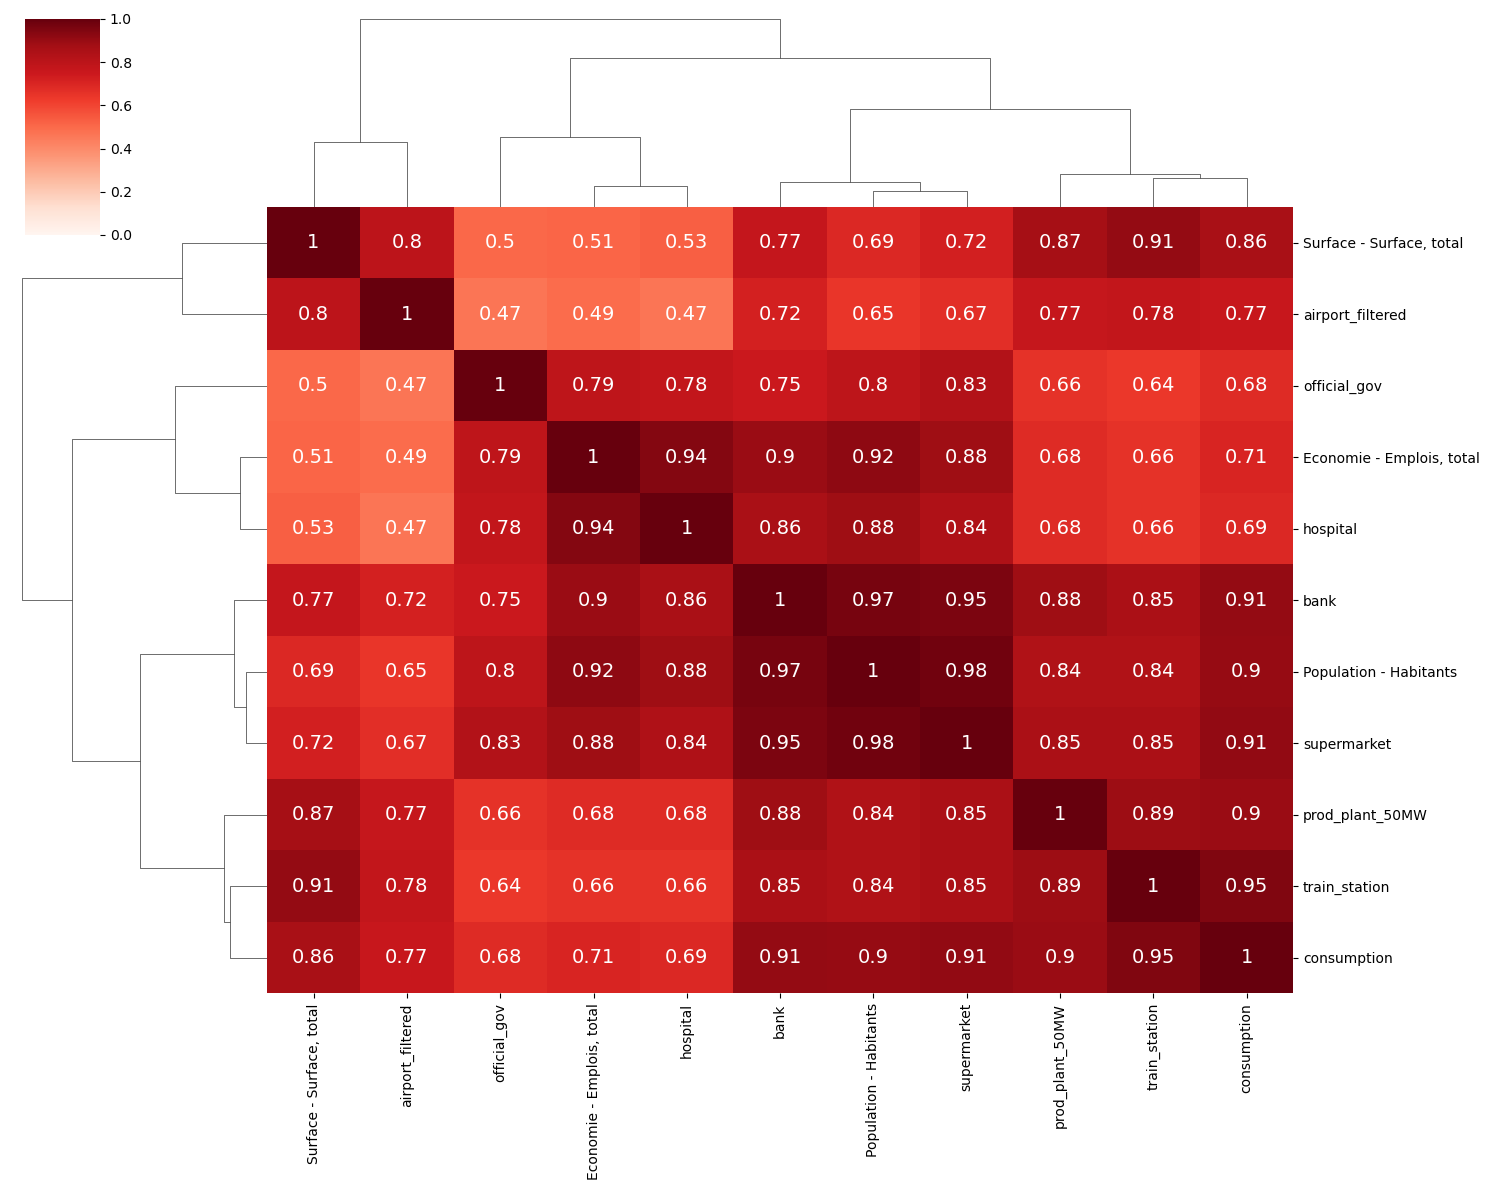

In [8]:
# Consider correlation between pop/surface and infrastucture
corr = aggregated_by_GRD.iloc[:, :-5].corr("pearson")

sns.clustermap(
    corr,
    method="complete",
    cmap="Reds",
    annot=True,
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
    figsize=(15, 12),
)


We have a large correlation between the variables. We take the log and observe if there is a linear relationship with the population variable.

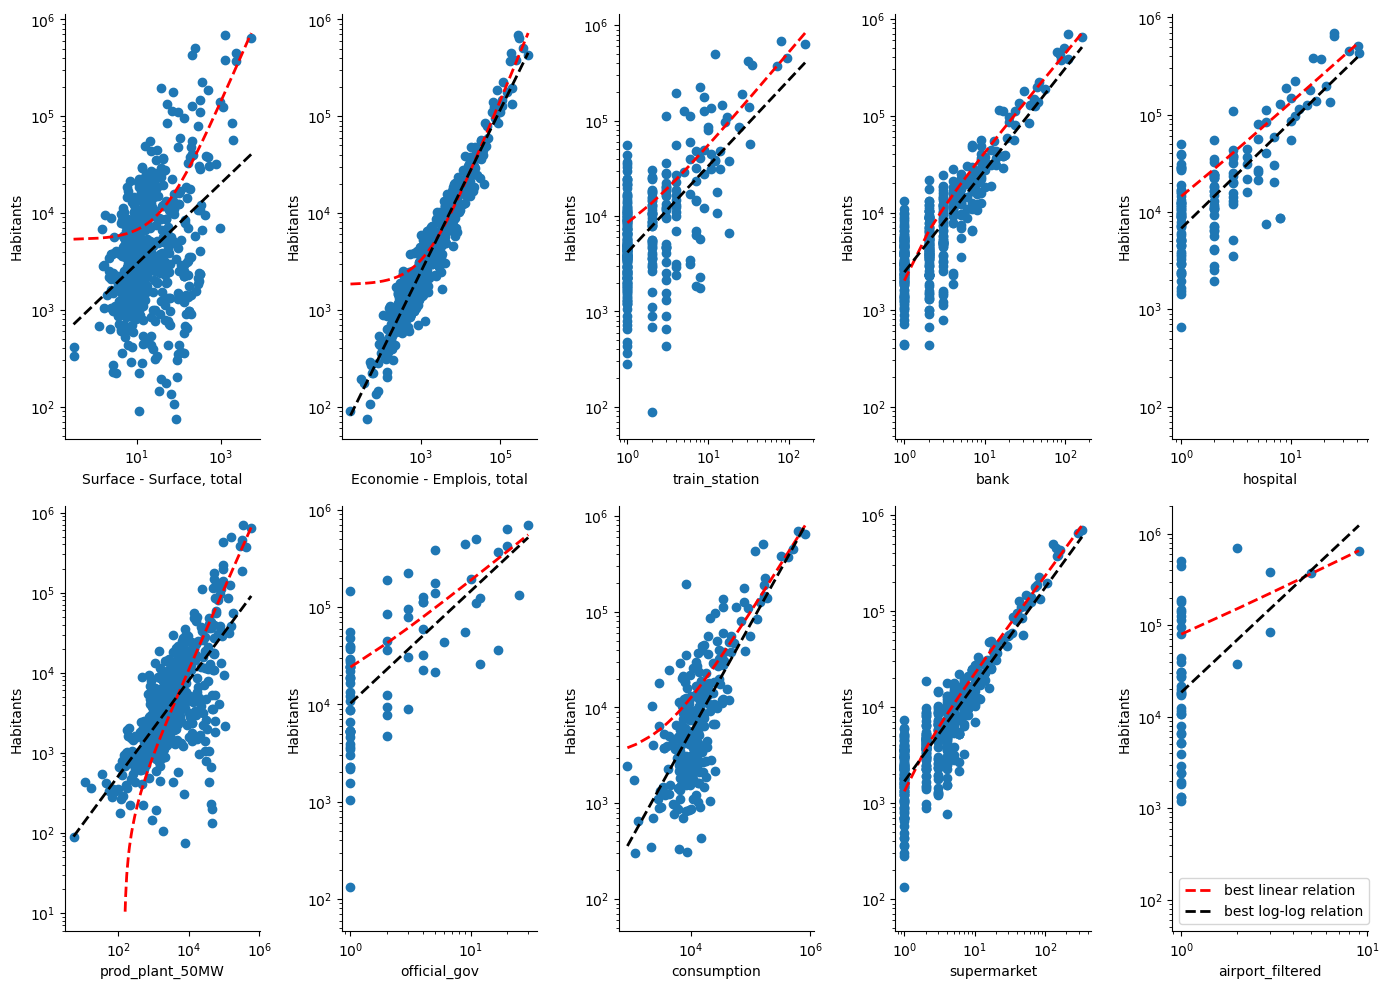

In [9]:
X = aggregated_by_GRD.copy()
fig = helpers.plot_pairwise(X, X.columns[1:-5], "Population - Habitants", "Habitants")


## Preprocessing
We first apply log to some features and scale the variables between 0 and 1.

In [10]:
apply_log_col = [
    "Population - Habitants",
    "Surface - Surface, total",
    "Economie - Emplois, total",
    "train_station",
    "bank",
    "hospital",
    "official_gov",
    "supermarket",
    "prod_plant_50MW",
]

# We don't use airport_filtered and consumption features.
# Why?
# 1) airport_filtered is discrete with small values. Clustering on this variable is difficult as the algorithm will use the gap between
#    discrete values to make clusters. Also the meaning of this variable is rather broad, as small airports and international airport are grouped together
# 2) consumption are obtained via a simulation. The problem with this variable is that some municipalities do not have any HV stations on its
#    ground. Hence, the measured consumption is 0, which is not representative. This artifact also makes the clustering more difficult,
#    as the difference between having or not having a HV stations on its ground will be exploited by the algorithm to find clusters.
X_with_name = aggregated_by_GRD.drop(columns=["airport_filtered", "consumption"]).copy()
X = X_with_name.copy()

preprocessing = "LogMinMax"
# Apply log to some columns
for c in apply_log_col:
    X[c] = np.log(X[c] + 1)

# Apply min-max scaling (maybe using the quantile 10% and 90% is a better option)
X = MinMaxScaler().fit_transform(X)
weighting_name = None  # Change here the weighting ["economic","vuln","energie"]
weights = helpers.weighting_scheme(weighting_name, X_with_name.columns)
if weighting_name is None:
    weighting_name = "None"
X *= weights


We first apply a dimension reduction. We first check with PCA.
We observe a decrease of the eigenvalues after 5 dimensions using PCA. Hence a non-linear transformation should use at most 5 dimensions.

In [11]:
# method="standard"
cluster_dim = 5
pca = False  # Set to True if you want to check with PCA
if cluster_dim is None:
    # No dimension reduction
    X_reduc = X
else:
    if pca:
        dim_reduc = PCA(cluster_dim)
    else:
        # dim_reduc=LocallyLinearEmbedding(n_neighbors=30,method=method, n_components=cluster_dim)
        dim_reduc = Isomap(n_neighbors=30, p=2, n_components=cluster_dim)
    X_reduc = dim_reduc.fit_transform(X)
    if pca:
        _ = helpers.my_PCA(
            pd.DataFrame(X, index=X_with_name.index, columns=X_with_name.columns),
            cluster_dim,
        )


Projection of the data in 2 dimensions

In [12]:
# tsne = TSNE(n_components=2, verbose = 1,perplexity=10,n_iter=5000)
proj = umap.UMAP(n_components=2, verbose=1, n_neighbors=50)
X_vis = proj.fit_transform(X_reduc)


UMAP(n_neighbors=50, verbose=1)
Mon Nov 28 09:48:20 2022 Construct fuzzy simplicial set
Mon Nov 28 09:48:20 2022 Finding Nearest Neighbors
Mon Nov 28 09:48:22 2022 Finished Nearest Neighbor Search
Mon Nov 28 09:48:24 2022 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:02]

Mon Nov 28 09:48:27 2022 Finished embedding


  0%|          | 0/10 [00:00<?, ?it/s]

For n_clusters = 3 The average silhouette_score is : 0.33630343502159976
For n_clusters = 4 The average silhouette_score is : 0.33478559724185786


 10%|█         | 1/10 [00:00<00:04,  1.89it/s]

For n_clusters = 5 The average silhouette_score is : 0.29246651868490803


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


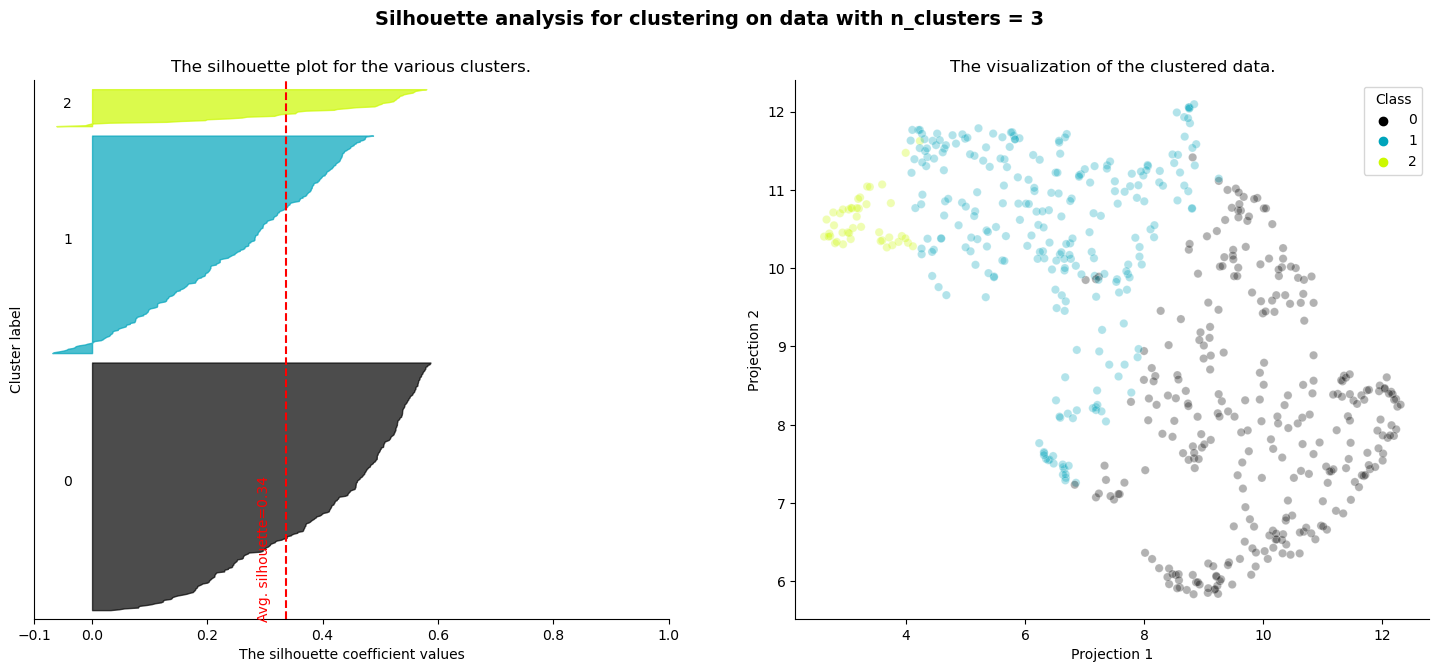

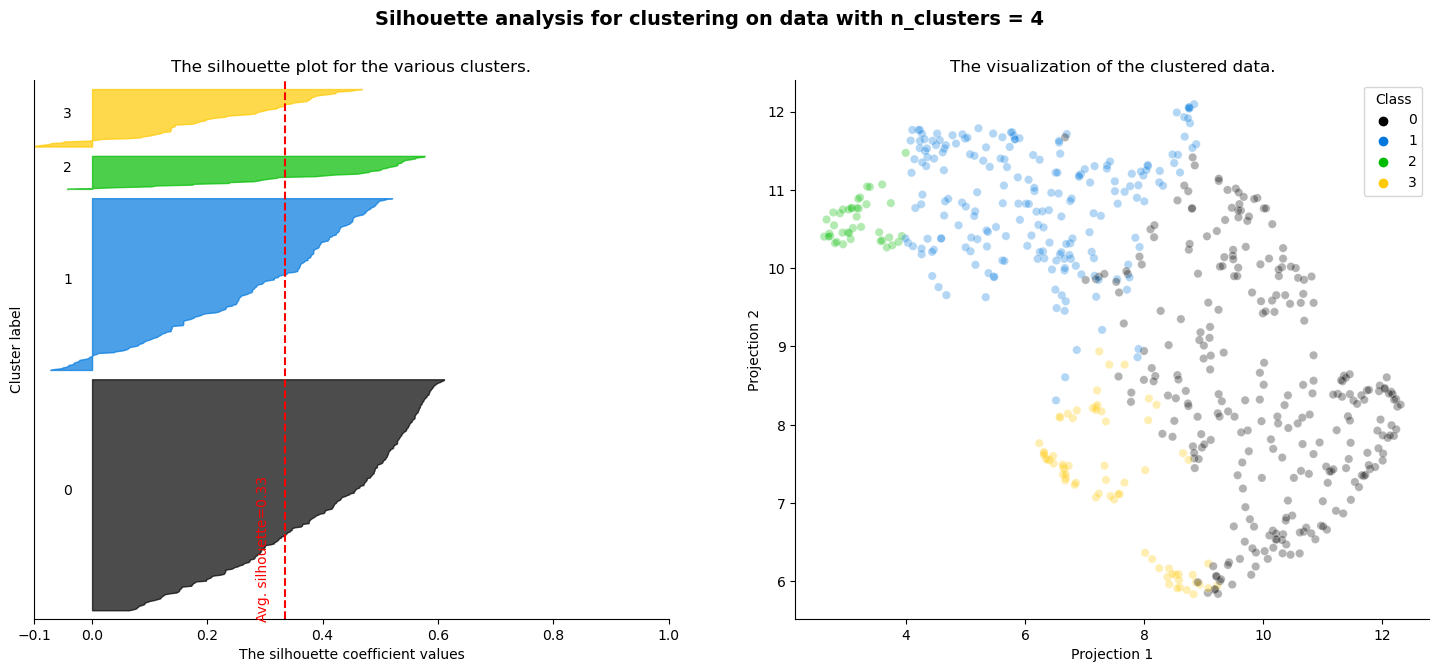

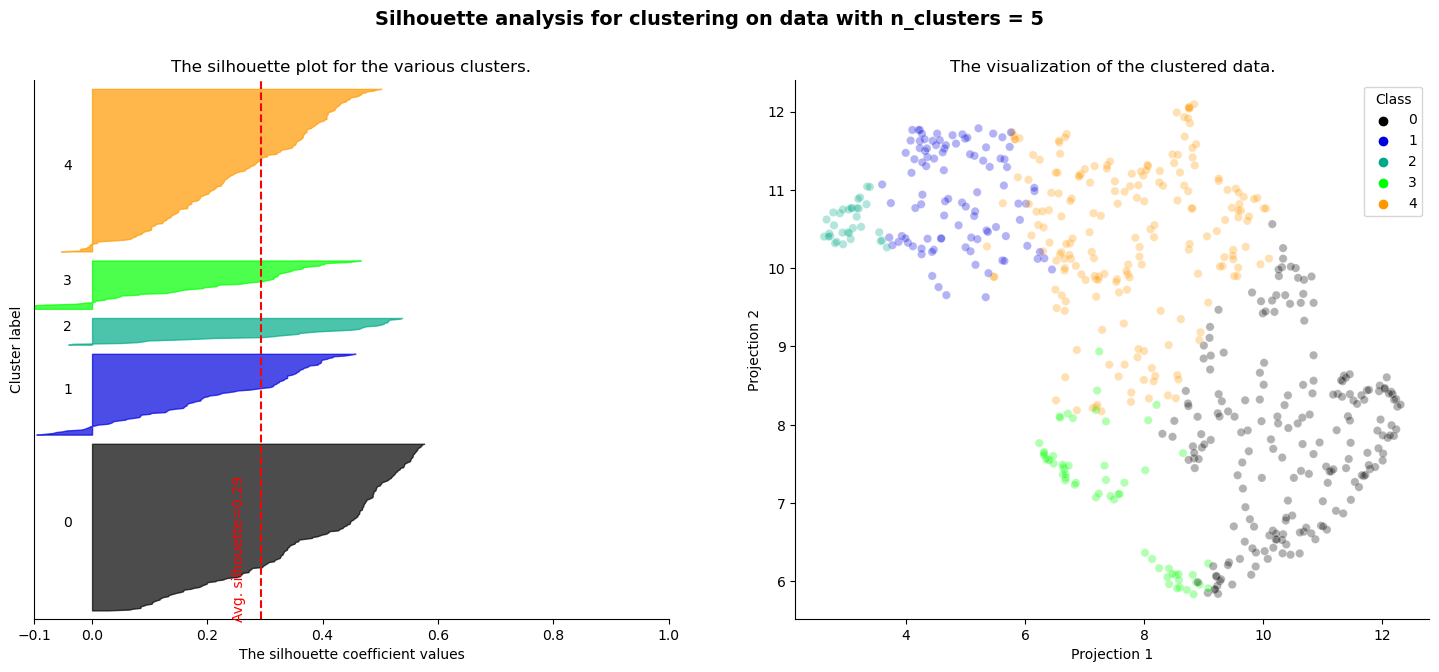

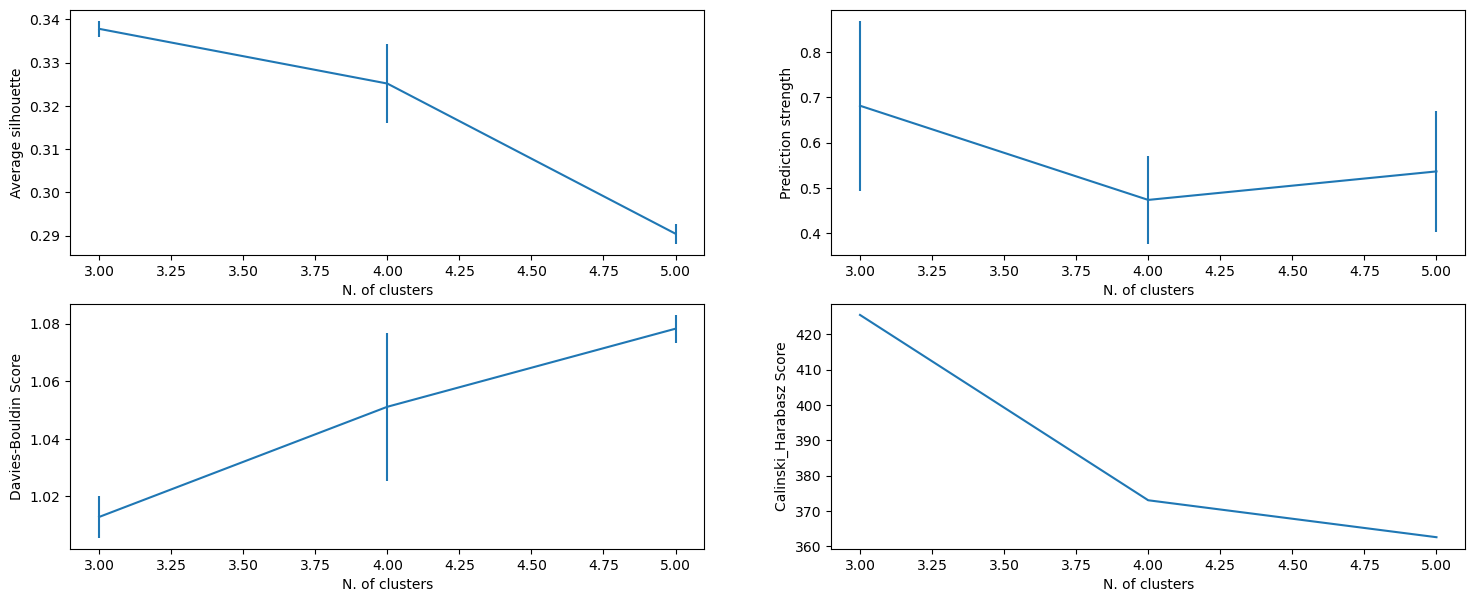

In [13]:
# Set the seed
np.random.seed(0)

save = False

# Parameters that can be changed
name_model = "KMeans"
metric = "l2"
smallest = 3
largest = 5

# Number of repetition to estimate confidence intervals
rep = 10

# Store values
pred_strength_ = np.zeros((rep, largest - smallest + 1))
avg_silhouette = np.zeros((rep, largest - smallest + 1))
davies_bouldin_ = pred_strength_.copy()
bic = pred_strength_.copy()
calinski_harabasz_ = pred_strength_.copy()
for i in tqdm(range(rep)):
    for j, n_clusters in enumerate(range(smallest, largest + 1)):
        pred_strength, sil, davies, calinski, bic_ = helpers.compute_cluster(
            n_clusters,
            X_reduc,
            name_model,
            metric,
            compute_figure=i == 0,
            save_figure=save,
            filename=f"{preprocessing}_{cluster_dim}_{name_model}_{metric}_{n_clusters}_no_airport_conso_weighting_{weighting_name}",
            X_vis=X_vis,
        )
        pred_strength_[i, j] = pred_strength
        avg_silhouette[i, j] = sil
        davies_bouldin_[i, j] = davies
        calinski_harabasz_[i, j] = calinski
        bic[i, j] = bic_

fig = helpers.plot_metrics(
    smallest,
    largest,
    name_model,
    pred_strength_,
    avg_silhouette,
    davies_bouldin_,
    bic,
    calinski_harabasz_,
)


Look at the projection and the correlation with the data

/var/folders/rw/qcr1zxbs5rz8z69lz349s8cc0000gp/T/ipykernel_44776/3616827310.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


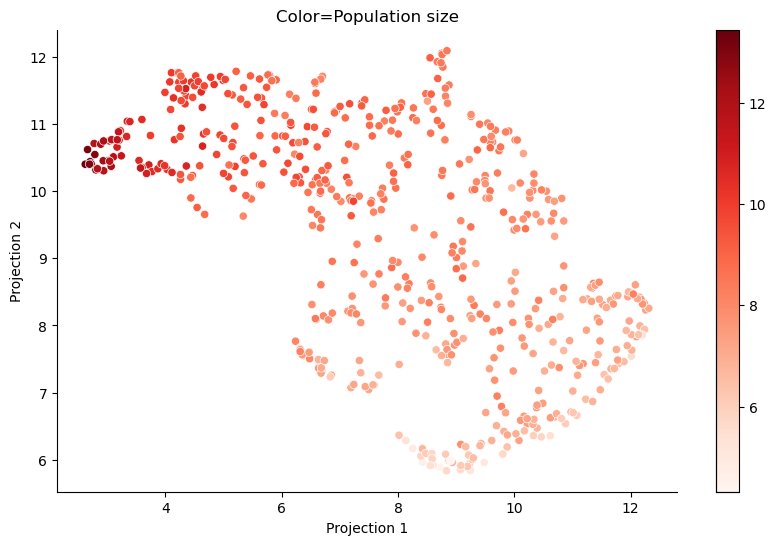

In [14]:
column = 0 # Choose the column index
X_vis_names = pd.DataFrame(X_vis, columns=["proj1", "proj2"], index=X_with_name.index)
data = pd.concat((X_vis_names, np.log(X_with_name.iloc[:, column] + 1)), axis=1)
col_color = data.columns[-1]
plt.figure(figsize=(10,6))
ax=plt.gca()
ax = sns.scatterplot(x="proj1", y="proj2", hue=col_color, palette="Reds", data=data,ax=ax)
plt.title(f"Color={'Population size'}")
plt.xlabel("Projection 1")
plt.ylabel("Projection 2")
norm = plt.Normalize(data[col_color].min(), data[col_color].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
sns.despine(plt.gcf())
plt.show()


Final clustering, based on the previous analysis

In [15]:
# Set the seed
np.random.seed(0)

save = True

# Parameters that can be changed
name_model = "KMeans"
metric = "l2"
n_clusters = 4

cluster_index_ = helpers.compute_cluster(
    n_clusters,
    X_reduc,
    name_model,
    metric,
    compute_figure=i == 0,
    save_figure=save,
    filename=f"{preprocessing}_{cluster_dim}_{name_model}_{metric}_{n_clusters}_no_airport_conso_weighting_{weighting_name}",
    X_vis=X_vis,
    return_metrics=False,
)


Sort the cluster index according to population size

In [16]:
tmp = pd.DataFrame(
    cluster_index_, index=aggregated_by_GRD.index, columns=["cluster_index"]
).reset_index()
# Add the clustering index to the features
classified = pd.merge(tmp, aggregated_by_GRD, left_on="Name", right_index=True)
cluster_index_ = helpers.order_clustering(tmp, classified, n_clusters)
classified = pd.merge(cluster_index_, aggregated_by_GRD, left_on="Name", right_index=True)

/Users/amari/Documents/SDSC/ofen/cyber_index/code/helpers.py:391: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classified.groupby("cluster_index").mean().sort_values("Population - Habitants")


In [17]:
# Save clusters
if save:
    path = os.path.join(
        "../clusters",
        f"{preprocessing}_{cluster_dim}_{name_model}_{metric}_{n_clusters}_no_airport_conso_weighting_{weighting_name}.csv",
    )
    cluster_index_.to_csv(
        path,
        index=False,
    )


# Clustering based on fixed thresholds
Current method in SFOE:
- Lowest class GRD: < 5200 capita
- Lower class GRD: <= 5200 capita, <21000 capita
- Middle class GRD: >= 21000 capita, <84000 capita
- Upper class GRD: > 84000 capita

In [10]:
def classification(x):
    if x<5200:
        return 0
    elif x<21000:
        return 1
    elif x < 84000:
        return 2
    else:
        return 3
classified=aggregated_by_GRD.copy()
classified["cluster_index"]=aggregated_by_GRD["Population - Habitants"].apply(classification)
path=os.path.join("../clusters","SFOE.csv")
classified["cluster_index"].reset_index().to_csv(path,index=False)